# Système Multi-Agents pour l'Ordonnancement Hospitalier

## III.3. Présentation du système multi-agents (SMA)

Ce notebook présente l'architecture complète du système multi-agents (SMA) conçu pour optimiser l'ordonnancement des soins dans un service d'urgences hospitalières.

---

### III.3.1. Rappel du principe théorique et application au SUA

Un **Système Multi-Agents (SMA)** est un ensemble d'entités autonomes (agents) capables de :
- **Percevoir** leur environnement
- **Décider** d'actions à entreprendre
- **Communiquer** entre eux via des protocoles d'interaction
- **Agir** de manière coordonnée pour atteindre un objectif commun

Dans notre contexte hospitalier (Service d'Urgences Adultes - SUA), le SMA modélise le flux de prise en charge des patients :

1. **Arrivée** d'un patient → L'Agent Accueil analyse son cas
2. **Identification** des ressources → L'Agent Identificateur vérifie la disponibilité du personnel et des compétences
3. **Ordonnancement** → L'Agent Ordonnanceur génère le planning optimal via des métaheuristiques

Ce cycle reproduit la vie réelle d'un service d'urgences, où chaque perturbation (nouveau patient, absence de personnel) déclenche une réorganisation dynamique.

---
### III.3.2. Description de l'architecture SMA

L'architecture repose sur **3 agents spécialisés** qui communiquent via des messages structurés :

```
┌──────────────────┐     ┌──────────────────────┐     ┌──────────────────────┐
│  AGENT ACCUEIL   │────▶│ AGENT IDENTIFICATEUR │────▶│ AGENT ORDONNANCEUR   │
│                  │     │                      │     │                      │
│ • Accueille les  │     │ • Gère le registre   │     │ • Génère le planning  │
│   patients       │     │   du personnel       │     │   optimal            │
│ • Analyse les    │     │ • Vérifie les        │     │ • Utilise 3 méta-    │
│   compétences    │◀────│   disponibilités     │◀────│   heuristiques       │
│   nécessaires    │     │ • Détecte les        │     │ • Recuit Simulé      │
│ • Gère la file   │     │   absences           │     │ • Recherche Tabou    │
│   d'attente      │     │ • Déclenche les      │     │ • Algo Génétique     │
│                  │     │   ré-ordonnancements  │     │                      │
└──────────────────┘     └──────────────────────┘     └──────────────────────┘
```

In [1]:
# ============================================================
# IMPORTS ET CONFIGURATION
# ============================================================
import sys
import os
import json
import random
import math
import copy
import time
from pathlib import Path
from enum import Enum
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple, Any
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Ajouter le répertoire courant au path
sys.path.insert(0, os.path.dirname(os.path.abspath('__file__')))

# Import des fonctions du projet existant
from data.generator import load_competence_matrix, create_patient_data

print("Imports OK")

Imports OK


---
## 1. Structures de données partagées

Avant de définir les agents, nous définissons les structures de données qui circulent entre eux : les patients, les messages inter-agents, et l'état des ressources.

In [2]:
# ============================================================
# STRUCTURES DE DONNÉES
# ============================================================

class Urgence(Enum):
    """Niveaux de tri des urgences (Classification CIMU)"""
    CRITIQUE = 1      # Pronostic vital immédiat
    TRES_URGENT = 2   # Atteinte fonctionnelle sévère
    URGENT = 3        # Situation nécessitant soins rapides
    MOINS_URGENT = 4  # Soins dans un délai raisonnable
    NON_URGENT = 5    # Consultation simple


class MessageType(Enum):
    """Types de messages échangés entre agents"""
    NOUVEAU_PATIENT = "nouveau_patient"           # Accueil → Identificateur
    DEMANDE_RESSOURCES = "demande_ressources"     # Ordonnanceur → Identificateur 
    REPONSE_RESSOURCES = "reponse_ressources"     # Identificateur → Ordonnanceur
    LANCER_ORDONNANCEMENT = "lancer_ordonnancement" # Accueil → Ordonnanceur
    PLANNING_GENERE = "planning_genere"           # Ordonnanceur → Accueil
    ABSENCE_PERSONNEL = "absence_personnel"       # Identificateur → Ordonnanceur
    RE_ORDONNANCEMENT = "re_ordonnancement"       # Identificateur → Ordonnanceur


class StatutPersonnel(Enum):
    """Statut d'un membre du personnel"""
    DISPONIBLE = "disponible"
    OCCUPE = "occupé"
    ABSENT = "absent"
    EN_PAUSE = "en_pause"


@dataclass
class Patient:
    """Représente un patient arrivant aux urgences"""
    id: int
    nom: str
    urgence: Urgence
    heure_arrivee: float                         # Temps de simulation
    operations: List[List[int]] = field(default_factory=list)  # [[comp1, comp2, ...], ...]
    competences_requises: set = field(default_factory=set)
    statut: str = "en_attente"                   # en_attente, en_cours, termine


@dataclass
class Personnel:
    """Représente un membre du personnel hospitalier"""
    id: int
    nom: str
    competences: List[int]     # Indices des compétences maîtrisées
    statut: StatutPersonnel = StatutPersonnel.DISPONIBLE
    charge_travail: float = 0.0


@dataclass
class Message:
    """Message échangé entre agents"""
    type: MessageType
    emetteur: str
    destinataire: str
    contenu: Any
    timestamp: float = 0.0
    priorite: int = 0

    def __repr__(self):
        return f"[{self.type.value}] {self.emetteur} → {self.destinataire} (t={self.timestamp:.1f})"


print("Structures de données définies :")
print(f"  - Urgence : {[u.name for u in Urgence]}")
print(f"  - MessageType : {[m.name for m in MessageType]}")
print(f"  - StatutPersonnel : {[s.name for s in StatutPersonnel]}")

Structures de données définies :
  - Urgence : ['CRITIQUE', 'TRES_URGENT', 'URGENT', 'MOINS_URGENT', 'NON_URGENT']
  - MessageType : ['NOUVEAU_PATIENT', 'DEMANDE_RESSOURCES', 'REPONSE_RESSOURCES', 'LANCER_ORDONNANCEMENT', 'PLANNING_GENERE', 'ABSENCE_PERSONNEL', 'RE_ORDONNANCEMENT']
  - StatutPersonnel : ['DISPONIBLE', 'OCCUPE', 'ABSENT', 'EN_PAUSE']


---
## 2. Fonctions de décodage et d'évaluation (moteur d'ordonnancement)

Ces fonctions sont le cœur du moteur d'ordonnancement. Elles transforment un chromosome (ordre des opérations) en un planning concret et calculent le **makespan** (CMax = durée totale).

In [3]:
# ============================================================
# FONCTIONS DE DÉCODAGE ET ÉVALUATION
# ============================================================

def decode_chromosome(chromosome, competence_matrix):
    """
    Décode un chromosome (ordre des opérations) en planning concret.
    
    Principe :
    - Lit les gènes [patient, op_idx] dans l'ordre du chromosome
    - Planifie chaque opération dès que sa précédence est respectée
    - Place chaque bloc de compétence de manière consécutive sur le créneau le plus tôt
    
    Args:
        chromosome: Liste de [patient, op_idx] 
        competence_matrix: Matrice [patient][operation][skill]
    
    Returns:
        solution: Matrice [skill][time] contenant (patient, op_idx) ou None
    """
    nb_patient = len(competence_matrix)
    nb_skills = len(competence_matrix[0][0])

    solution = [[] for _ in range(nb_skills)]
    next_op = [0 for _ in range(nb_patient)]
    patient_end = [0 for _ in range(nb_patient)]

    total_ops = sum(len(competence_matrix[p]) for p in range(nb_patient))
    scheduled_ops = 0

    while scheduled_ops < total_ops:
        progress = False

        for patient, op_idx in chromosome:
            if op_idx != next_op[patient]:
                continue

            operation = competence_matrix[patient][op_idx]
            last_time_for_operation = patient_end[patient]

            for skill in range(nb_skills):
                skill_time = operation[skill]
                if skill_time <= 0:
                    continue

                t = patient_end[patient]
                while True:
                    current_len = len(solution[0]) if solution[0] else 0
                    while t + skill_time > current_len:
                        for skill_row in solution:
                            skill_row.append(None)
                        current_len += 1

                    bloc_libre = all(solution[skill][tau] is None for tau in range(t, t + skill_time))

                    if bloc_libre:
                        for tau in range(t, t + skill_time):
                            solution[skill][tau] = (patient, op_idx)
                        fin_bloc = t + skill_time - 1
                        if fin_bloc > last_time_for_operation:
                            last_time_for_operation = fin_bloc
                        break
                    else:
                        t += 1

            patient_end[patient] = last_time_for_operation + 1
            next_op[patient] += 1
            scheduled_ops += 1
            progress = True
            break

        if not progress:
            return solution

    return solution


def calculate_makespan(solution):
    """Calcule le CMax d'une solution décodée."""
    if not solution or not solution[0]:
        return 0
    return len(solution[0])


def create_random_solution(competence_matrix):
    """Crée une solution aléatoire (chromosome)."""
    operations = []
    for patient in range(len(competence_matrix)):
        for op_idx in range(len(competence_matrix[patient])):
            operations.append([patient, op_idx])
    random.shuffle(operations)
    return operations


def evaluate_solution(operations, competence_matrix):
    """Évalue une solution et retourne son makespan."""
    solution = decode_chromosome(operations, competence_matrix)
    return calculate_makespan(solution)


print("Fonctions de décodage/évaluation prêtes.")

Fonctions de décodage/évaluation prêtes.


---
## III.3.2.1. Agent Accueil

L'**Agent Accueil** est le point d'entrée du système. Son rôle :

- **Accueillir** les nouveaux patients arrivant aux urgences
- **Analyser** le cas de chaque patient pour identifier les compétences nécessaires au soin
- **Gérer la file d'attente** en triant les patients par niveau d'urgence (classification CIMU)
- **Communiquer** avec l'Agent Identificateur pour signaler les besoins en compétences
- **Déclencher** l'ordonnancement quand de nouveaux patients doivent être planifiés

Il maintient la liste des patients en attente et construit la **matrice de compétences** nécessaire à l'ordonnancement.

In [4]:
# ============================================================
# AGENT ACCUEIL
# ============================================================

class AgentAccueil:
    """
    Agent Accueil : Point d'entrée des patients aux urgences.
    
    Responsabilités :
    - Accueil et enregistrement des patients
    - Analyse des besoins en compétences pour chaque patient
    - Gestion de la file d'attente triée par urgence
    - Communication avec l'Identificateur et l'Ordonnanceur
    """
    
    def __init__(self, nom="Accueil"):
        self.nom = nom
        self.patients_en_attente: List[Patient] = []  # File d'attente triée par urgence
        self.patients_en_cours: List[Patient] = []    # Patients en cours de traitement
        self.patients_termines: List[Patient] = []    # Historique
        self.compteur_patients = 0
        self.boite_messages: List[Message] = []
        self.log: List[str] = []
        self.planning_actuel = None
        
    def accueillir_patient(self, operations: List[List[int]], 
                           urgence: Urgence = None, 
                           nom: str = None,
                           timestamp: float = 0.0) -> Patient:
        """
        Accueille un nouveau patient aux urgences.
        
        1. Crée la fiche patient
        2. Analyse les compétences requises
        3. L'ajoute à la file d'attente (triée par urgence)
        
        Args:
            operations: Liste des opérations [[comp1, comp2, ...], ...]
            urgence: Niveau d'urgence (aléatoire si non spécifié)
            nom: Nom du patient (généré si non spécifié)
            timestamp: Temps de simulation
            
        Returns:
            Patient créé
        """
        self.compteur_patients += 1
        
        if urgence is None:
            # Distribution réaliste des urgences
            urgence = random.choices(
                list(Urgence),
                weights=[5, 15, 35, 30, 15],  # Plus de cas urgents/moins urgents
                k=1
            )[0]
        
        if nom is None:
            nom = f"Patient_{self.compteur_patients:03d}"
        
        # Analyse des compétences requises
        competences_requises = self._analyser_competences(operations)
        
        patient = Patient(
            id=self.compteur_patients,
            nom=nom,
            urgence=urgence,
            heure_arrivee=timestamp,
            operations=operations,
            competences_requises=competences_requises
        )
        
        # Insérer dans la file d'attente triée par urgence (1=critique en premier)
        self.patients_en_attente.append(patient)
        self.patients_en_attente.sort(key=lambda p: (p.urgence.value, p.heure_arrivee))
        
        self._log(f"[t={timestamp:.1f}] Patient {patient.nom} accueilli | "
                  f"Urgence: {urgence.name} | "
                  f"{len(operations)} opérations | "
                  f"Compétences requises: {competences_requises}")
        
        return patient
    
    def _analyser_competences(self, operations: List[List[int]]) -> set:
        """
        Analyse les opérations d'un patient pour identifier les compétences nécessaires.
        Retourne l'ensemble des indices de compétences nécessaires (valeur > 0).
        """
        competences = set()
        for op in operations:
            for idx, val in enumerate(op):
                if val > 0:
                    competences.add(idx)
        return competences
    
    def construire_matrice_competences(self) -> List[List[List[int]]]:
        """
        Construit la matrice de compétences à partir des patients en attente.
        C'est cette matrice qui sera envoyée à l'Agent Ordonnanceur.
        
        Returns:
            competence_matrix[patient][operation][skill]
        """
        return [patient.operations for patient in self.patients_en_attente]
    
    def demander_ordonnancement(self, timestamp: float = 0.0) -> Message:
        """
        Envoie une demande d'ordonnancement à l'Agent Ordonnanceur.
        Inclut la matrice de compétences construite à partir de la file d'attente.
        """
        matrice = self.construire_matrice_competences()
        
        # Résumé des compétences nécessaires (union de toutes les compétences)
        toutes_competences = set()
        for patient in self.patients_en_attente:
            toutes_competences.update(patient.competences_requises)
        
        msg = Message(
            type=MessageType.LANCER_ORDONNANCEMENT,
            emetteur=self.nom,
            destinataire="Ordonnanceur",
            contenu={
                "competence_matrix": matrice,
                "nb_patients": len(self.patients_en_attente),
                "competences_requises": list(toutes_competences),
                "patients_info": [
                    {"id": p.id, "nom": p.nom, "urgence": p.urgence.name, 
                     "nb_ops": len(p.operations)}
                    for p in self.patients_en_attente
                ]
            },
            timestamp=timestamp,
            priorite=min(p.urgence.value for p in self.patients_en_attente) if self.patients_en_attente else 5
        )
        
        self._log(f"[t={timestamp:.1f}] Demande d'ordonnancement envoyée | "
                  f"{len(self.patients_en_attente)} patients | "
                  f"Compétences nécessaires: {toutes_competences}")
        
        return msg
    
    def signaler_nouveau_patient(self, patient: Patient, timestamp: float = 0.0) -> Message:
        """
        Signale un nouveau patient à l'Agent Identificateur pour vérifier
        que les compétences requises sont disponibles.
        """
        msg = Message(
            type=MessageType.NOUVEAU_PATIENT,
            emetteur=self.nom,
            destinataire="Identificateur",
            contenu={
                "patient_id": patient.id,
                "patient_nom": patient.nom,
                "urgence": patient.urgence.name,
                "competences_requises": list(patient.competences_requises),
                "nb_operations": len(patient.operations)
            },
            timestamp=timestamp,
            priorite=patient.urgence.value
        )
        return msg
    
    def recevoir_planning(self, message: Message):
        """Reçoit le planning généré par l'ordonnanceur."""
        self.planning_actuel = message.contenu
        self._log(f"[t={message.timestamp:.1f}] Planning reçu | "
                  f"CMax = {message.contenu.get('makespan', '?')}")
        
        # Passer les patients en attente en cours de traitement
        for patient in self.patients_en_attente:
            patient.statut = "en_cours"
            self.patients_en_cours.append(patient)
        self.patients_en_attente.clear()
    
    def get_etat(self) -> dict:
        """Retourne l'état actuel de l'agent."""
        return {
            "agent": self.nom,
            "patients_en_attente": len(self.patients_en_attente),
            "patients_en_cours": len(self.patients_en_cours),
            "patients_termines": len(self.patients_termines),
            "total_accueillis": self.compteur_patients
        }
    
    def _log(self, message: str):
        self.log.append(message)
    
    def afficher_file_attente(self):
        """Affiche la file d'attente actuelle."""
        print(f"\n{'='*60}")
        print(f"  FILE D'ATTENTE — Agent {self.nom}")
        print(f"{'='*60}")
        if not self.patients_en_attente:
            print("  (vide)")
        for i, p in enumerate(self.patients_en_attente, 1):
            urgence_colors = {1: '🔴', 2: '🟠', 3: '🟡', 4: '🟢', 5: '⚪'}
            emoji = urgence_colors.get(p.urgence.value, '⚪')
            print(f"  {i}. {emoji} {p.nom} | Urgence: {p.urgence.name} | "
                  f"{len(p.operations)} ops | Arrivée: t={p.heure_arrivee:.1f}")
        print(f"{'='*60}\n")


print("Agent Accueil défini.")

Agent Accueil défini.


---
## III.3.2.2. Agent Identificateur

L'**Agent Identificateur** gère les ressources humaines du service. Son rôle :

- **Maintenir le registre** du personnel avec leurs compétences et disponibilités
- **Vérifier la disponibilité** des compétences requises pour les patients
- **Détecter les absences** et changements de situation du personnel
- **Déclencher un ré-ordonnancement** quand les ressources changent (absence imprévue, arrivée de renfort)
- **Répondre** aux demandes de ressources de l'Agent Ordonnanceur

C'est le garant de la cohérence entre le planning et la réalité du terrain.

In [5]:
# ============================================================
# AGENT IDENTIFICATEUR
# ============================================================

class AgentIdentificateur:
    """
    Agent Identificateur : Gestionnaire des ressources hospitalières.
    
    Responsabilités :
    - Registre du personnel et des compétences
    - Suivi des disponibilités en temps réel
    - Détection des absences et perturbations
    - Déclenchement des ré-ordonnancements
    """
    
    def __init__(self, nom="Identificateur"):
        self.nom = nom
        self.registre_personnel: List[Personnel] = []
        self.boite_messages: List[Message] = []
        self.log: List[str] = []
        self.alertes: List[str] = []  # Alertes de ressources
        self.historique_absences: List[dict] = []
    
    def enregistrer_personnel(self, nom: str, competences: List[int]) -> Personnel:
        """
        Enregistre un nouveau membre du personnel.
        
        Args:
            nom: Nom du personnel
            competences: Liste des indices de compétences maîtrisées
            
        Returns:
            Personnel créé
        """
        personnel = Personnel(
            id=len(self.registre_personnel) + 1,
            nom=nom,
            competences=competences
        )
        self.registre_personnel.append(personnel)
        self._log(f"Personnel enregistré: {nom} | Compétences: {competences}")
        return personnel
    
    def generer_equipe(self, nb_personnel: int, nb_competences: int):
        """
        Génère une équipe de personnel avec des compétences variées.
        Simule une équipe hospitalière réaliste.
        """
        roles = [
            "Dr.", "Inf.", "Aide-soignant(e)", "Interne", 
            "Spéc.", "Chirurg.", "Anesth."
        ]
        
        for i in range(nb_personnel):
            # Chaque personnel maîtrise 1 à 3 compétences
            nb_comp = random.randint(1, min(3, nb_competences))
            comps = sorted(random.sample(range(nb_competences), nb_comp))
            role = random.choice(roles)
            nom = f"{role} {chr(65 + i % 26)}{i // 26 + 1 if i >= 26 else ''}"
            self.enregistrer_personnel(nom, comps)
        
        self._log(f"Équipe de {nb_personnel} personnels générée")
    
    def verifier_disponibilite(self, competences_requises: set) -> dict:
        """
        Vérifie si les compétences requises sont couvertes par le personnel disponible.
        
        Args:
            competences_requises: Set des indices de compétences nécessaires
            
        Returns:
            Rapport de disponibilité avec couverture par compétence
        """
        disponibles = [p for p in self.registre_personnel 
                       if p.statut == StatutPersonnel.DISPONIBLE]
        
        couverture = {}
        for comp in competences_requises:
            personnel_qualifie = [
                p for p in disponibles if comp in p.competences
            ]
            couverture[comp] = {
                "couverte": len(personnel_qualifie) > 0,
                "nb_disponibles": len(personnel_qualifie),
                "personnel": [p.nom for p in personnel_qualifie]
            }
        
        toutes_couvertes = all(c["couverte"] for c in couverture.values())
        
        rapport = {
            "toutes_couvertes": toutes_couvertes,
            "nb_personnel_disponible": len(disponibles),
            "nb_personnel_total": len(self.registre_personnel),
            "couverture_par_competence": couverture
        }
        
        if not toutes_couvertes:
            manquantes = [c for c, info in couverture.items() if not info["couverte"]]
            alerte = f"⚠️ Compétences non couvertes: {manquantes}"
            self.alertes.append(alerte)
            self._log(alerte)
        
        return rapport
    
    def signaler_absence(self, personnel_id: int, timestamp: float = 0.0) -> Optional[Message]:
        """
        Gère l'absence d'un membre du personnel.
        Déclenche un ré-ordonnancement si nécessaire.
        
        Returns:
            Message de ré-ordonnancement si l'absence impacte le planning
        """
        personnel = None
        for p in self.registre_personnel:
            if p.id == personnel_id:
                personnel = p
                break
        
        if personnel is None:
            self._log(f"Personnel ID={personnel_id} non trouvé")
            return None
        
        ancien_statut = personnel.statut
        personnel.statut = StatutPersonnel.ABSENT
        
        self.historique_absences.append({
            "personnel_id": personnel_id,
            "nom": personnel.nom,
            "competences": personnel.competences,
            "timestamp": timestamp
        })
        
        self._log(f"[t={timestamp:.1f}] ⚠️ ABSENCE: {personnel.nom} | "
                  f"Compétences perdues: {personnel.competences}")
        
        # Vérifier si d'autres personnels couvrent les mêmes compétences
        competences_impactees = []
        for comp in personnel.competences:
            autres = [p for p in self.registre_personnel 
                     if p.statut == StatutPersonnel.DISPONIBLE and comp in p.competences]
            if len(autres) == 0:
                competences_impactees.append(comp)
        
        # Toujours déclencher un ré-ordonnancement en cas d'absence
        msg = Message(
            type=MessageType.RE_ORDONNANCEMENT,
            emetteur=self.nom,
            destinataire="Ordonnanceur",
            contenu={
                "raison": "absence_personnel",
                "personnel_absent": personnel.nom,
                "competences_perdues": personnel.competences,
                "competences_non_couvertes": competences_impactees,
                "impact_critique": len(competences_impactees) > 0
            },
            timestamp=timestamp,
            priorite=1 if competences_impactees else 3
        )
        
        self._log(f"  → Ré-ordonnancement déclenché "
                  f"(impact critique: {len(competences_impactees) > 0})")
        
        return msg
    
    def repondre_demande_ressources(self, message: Message, timestamp: float = 0.0) -> Message:
        """
        Répond à une demande de ressources de l'Agent Ordonnanceur.
        Retourne l'état complet des ressources disponibles.
        """
        competences_demandees = set(message.contenu.get("competences_requises", []))
        rapport = self.verifier_disponibilite(competences_demandees)
        
        reponse = Message(
            type=MessageType.REPONSE_RESSOURCES,
            emetteur=self.nom,
            destinataire="Ordonnanceur",
            contenu=rapport,
            timestamp=timestamp
        )
        
        self._log(f"[t={timestamp:.1f}] Réponse ressources envoyée | "
                  f"{rapport['nb_personnel_disponible']}/{rapport['nb_personnel_total']} dispo")
        
        return reponse
    
    def get_etat(self) -> dict:
        """Retourne l'état actuel des ressources."""
        status_counts = {}
        for s in StatutPersonnel:
            status_counts[s.name] = sum(1 for p in self.registre_personnel if p.statut == s)
        
        return {
            "agent": self.nom,
            "personnel_total": len(self.registre_personnel),
            "statuts": status_counts,
            "nb_alertes": len(self.alertes),
            "nb_absences": len(self.historique_absences)
        }
    
    def afficher_registre(self):
        """Affiche le registre du personnel."""
        print(f"\n{'='*65}")
        print(f"  REGISTRE DU PERSONNEL — Agent {self.nom}")
        print(f"{'='*65}")
        status_emoji = {
            StatutPersonnel.DISPONIBLE: '✅',
            StatutPersonnel.OCCUPE: '🔵',
            StatutPersonnel.ABSENT: '❌',
            StatutPersonnel.EN_PAUSE: '⏸️'
        }
        for p in self.registre_personnel:
            emoji = status_emoji.get(p.statut, '❓')
            comp_str = ', '.join([f'C{c+1}' for c in p.competences])
            print(f"  {emoji} {p.nom:25s} | Comp: [{comp_str}] | {p.statut.value}")
        print(f"{'='*65}\n")
    
    def _log(self, message: str):
        self.log.append(message)


print("Agent Identificateur défini.")

Agent Identificateur défini.


---
## III.3.2.3. Agent Ordonnanceur

L'**Agent Ordonnanceur** est le cerveau du système. Son rôle :

- **Demander** à l'Agent Identificateur quelles ressources sont disponibles (compétences, personnel)
- **Générer le planning optimal** en utilisant les méthodes multi-agents métaheuristiques :
  - **Recuit Simulé** : Exploration large de l'espace de solutions
  - **Recherche Tabou** : Intensification locale autour des bonnes solutions
  - **Algorithme Génétique** : Diversification et évolution des solutions
- **Coordonner** le pipeline d'optimisation entre les sous-agents métaheuristiques
- **Communiquer** le planning final à l'Agent Accueil

Il utilise un mode **pipeline** (SA → Tabu → GA) où chaque métaheuristique affine la solution de la précédente.

In [6]:
# ============================================================
# SOUS-AGENTS MÉTAHEURISTIQUES (internes à l'Ordonnanceur)
# ============================================================

class SousAgentRecuitSimule:
    """Sous-agent utilisant le Recuit Simulé pour l'exploration initiale."""
    
    def __init__(self, competence_matrix, temp_init=1000, cooling_rate=0.95):
        self.competence_matrix = competence_matrix
        self.temperature = temp_init
        self.temp_init = temp_init
        self.cooling_rate = cooling_rate
        self.best_order = create_random_solution(competence_matrix)
        self.makespan = evaluate_solution(self.best_order, competence_matrix)
        self.historique_makespan = [self.makespan]
        self.nom = "RecuitSimulé"
    
    def _generate_voisin(self, ordre):
        """Génère un voisin par swap respectant les contraintes de précédence."""
        for _ in range(100):
            nouvel_ordre = [gene[:] for gene in ordre]
            i, j = random.sample(range(len(nouvel_ordre)), 2)
            if nouvel_ordre[i][0] != nouvel_ordre[j][0]:
                nouvel_ordre[i], nouvel_ordre[j] = nouvel_ordre[j], nouvel_ordre[i]
                if self._verifier_precedence(nouvel_ordre):
                    return nouvel_ordre
        return ordre
    
    def _verifier_precedence(self, ordre):
        """Vérifie que les contraintes de précédence sont respectées."""
        dernieres_ops = {}
        for patient_id, op_id in ordre:
            if patient_id in dernieres_ops and op_id <= dernieres_ops[patient_id]:
                return False
            dernieres_ops[patient_id] = op_id
        return True
    
    def step(self):
        """Une itération du recuit simulé."""
        voisin = self._generate_voisin(self.best_order)
        ms_voisin = evaluate_solution(voisin, self.competence_matrix)
        
        delta = ms_voisin - self.makespan
        if delta < 0 or (self.temperature > 1e-8 and random.random() < math.exp(-delta / self.temperature)):
            self.best_order = voisin
            self.makespan = ms_voisin
        
        self.temperature *= self.cooling_rate
        self.historique_makespan.append(self.makespan)
    
    def reset(self, solution=None):
        """Réinitialise avec une nouvelle solution."""
        if solution:
            self.best_order = [gene[:] for gene in solution]
            self.makespan = evaluate_solution(self.best_order, self.competence_matrix)
        self.temperature = self.temp_init


class SousAgentTabou:
    """Sous-agent utilisant la Recherche Tabou pour l'intensification."""
    
    def __init__(self, competence_matrix, tenure=7, candidate_size=40):
        self.competence_matrix = competence_matrix
        self.tenure = tenure
        self.candidate_size = candidate_size
        self.current_order = create_random_solution(competence_matrix)
        self.best_order = [gene[:] for gene in self.current_order]
        self.makespan = evaluate_solution(self.best_order, competence_matrix)
        self.tabu_list = []
        self.iteration = 0
        self.historique_makespan = [self.makespan]
        self.nom = "RechercheTabou"
    
    def step(self):
        """Une itération de la recherche tabou."""
        candidates = []
        for _ in range(self.candidate_size):
            if len(self.current_order) < 2:
                continue
            i = random.randrange(len(self.current_order))
            j = random.randrange(len(self.current_order))
            if i == j:
                continue
            
            neighbor = [gene[:] for gene in self.current_order]
            elem = neighbor.pop(i)
            neighbor.insert(j, elem)
            
            ms = evaluate_solution(neighbor, self.competence_matrix)
            candidates.append((ms, neighbor, (i, j)))
        
        if not candidates:
            return
        
        candidates.sort(key=lambda x: x[0])
        self.tabu_list = [(i, j, exp) for i, j, exp in self.tabu_list if exp > self.iteration]
        
        for ms, neighbor, (i, j) in candidates:
            is_tabu = any((i == ti and j == tj) for ti, tj, _ in self.tabu_list)
            if (not is_tabu) or (ms < self.makespan):
                self.current_order = neighbor
                self.tabu_list.append((i, j, self.iteration + self.tenure))
                if ms < self.makespan:
                    self.best_order = [gene[:] for gene in neighbor]
                    self.makespan = ms
                break
        
        self.iteration += 1
        self.historique_makespan.append(self.makespan)
    
    def reset(self, solution=None):
        """Réinitialise avec une nouvelle solution."""
        if solution:
            self.current_order = [gene[:] for gene in solution]
            self.best_order = [gene[:] for gene in solution]
            self.makespan = evaluate_solution(self.best_order, self.competence_matrix)
        self.tabu_list = []
        self.iteration = 0


class SousAgentGenetique:
    """Sous-agent utilisant l'Algorithme Génétique pour la diversification."""
    
    def __init__(self, competence_matrix, population_size=20, mutation_rate=0.2):
        self.competence_matrix = competence_matrix
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        
        # Population initiale
        self.population = [create_random_solution(competence_matrix) for _ in range(population_size)]
        self.fitness_values, self.makespans = self._evaluate_population()
        
        best_idx = min(range(population_size), key=lambda i: self.makespans[i])
        self.best_order = [gene[:] for gene in self.population[best_idx]]
        self.makespan = self.makespans[best_idx]
        self.historique_makespan = [self.makespan]
        self.nom = "AlgoGénétique"
    
    def _evaluate_population(self):
        fitness_values, makespans = [], []
        for chrom in self.population:
            ms = evaluate_solution(chrom, self.competence_matrix)
            makespans.append(ms)
            fitness_values.append(1 / (1 + ms))
        return fitness_values, makespans
    
    def _roulette_selection(self):
        total = sum(self.fitness_values)
        if total == 0:
            return [gene[:] for gene in random.choice(self.population)]
        r = random.random()
        cumul = 0
        for chrom, fit in zip(self.population, self.fitness_values):
            cumul += fit / total
            if cumul >= r:
                return [gene[:] for gene in chrom]
        return [gene[:] for gene in self.population[-1]]
    
    def _lox_crossover(self, p1, p2):
        size = len(p1)
        a, b = sorted(random.sample(range(size), 2))
        child = [None] * size
        child[a:b+1] = [gene[:] for gene in p1[a:b+1]]
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while p2[p2_idx] in child:
                    p2_idx += 1
                child[i] = p2[p2_idx][:]
        return child
    
    def _mutate(self, chrom):
        if random.random() > self.mutation_rate:
            return chrom
        child = [gene[:] for gene in chrom]
        i, j = random.sample(range(len(child)), 2)
        child[i], child[j] = child[j], child[i]
        return child
    
    def step(self):
        """Une génération de l'algorithme génétique."""
        new_pop = [[gene[:] for gene in self.best_order]]  # Élitisme
        
        while len(new_pop) < self.population_size:
            p1 = self._roulette_selection()
            p2 = self._roulette_selection()
            child = self._lox_crossover(p1, p2)
            child = self._mutate(child)
            new_pop.append(child)
        
        self.population = new_pop
        self.fitness_values, self.makespans = self._evaluate_population()
        
        best_idx = min(range(len(self.population)), key=lambda i: self.makespans[i])
        if self.makespans[best_idx] < self.makespan:
            self.best_order = [gene[:] for gene in self.population[best_idx]]
            self.makespan = self.makespans[best_idx]
        
        self.historique_makespan.append(self.makespan)
    
    def inject_solution(self, solution, makespan):
        """Injecte une solution externe dans la population (remplacement du pire)."""
        worst_idx = max(range(len(self.population)), key=lambda i: self.makespans[i])
        self.population[worst_idx] = [gene[:] for gene in solution]
        self.makespans[worst_idx] = makespan
        self.fitness_values[worst_idx] = 1 / (1 + makespan)
        if makespan < self.makespan:
            self.best_order = [gene[:] for gene in solution]
            self.makespan = makespan


print("Sous-agents métaheuristiques définis (SA, Tabu, GA).")

Sous-agents métaheuristiques définis (SA, Tabu, GA).


In [7]:
# ============================================================
# AGENT ORDONNANCEUR
# ============================================================

class AgentOrdonnanceur:
    """
    Agent Ordonnanceur : Générateur du planning optimal.
    
    Responsabilités :
    - Demander les ressources à l'Identificateur
    - Orchestrer le pipeline de métaheuristiques (SA → Tabu → GA)
    - Générer et communiquer le planning final
    """
    
    def __init__(self, nom="Ordonnanceur", steps_par_phase=50):
        self.nom = nom
        self.competence_matrix = None
        self.boite_messages: List[Message] = []
        self.log: List[str] = []
        self.steps_par_phase = steps_par_phase
        
        # Sous-agents métaheuristiques (créés lors de l'ordonnancement)
        self.sa_agent = None
        self.tabu_agent = None
        self.ga_agent = None
        
        # Résultats
        self.meilleur_makespan = float('inf')
        self.meilleure_solution = None
        self.historique_global = []
        self.planning_decoded = None
    
    def demander_ressources(self, competences_requises: List[int], timestamp: float = 0.0) -> Message:
        """
        Envoie une demande de ressources à l'Agent Identificateur.
        """
        msg = Message(
            type=MessageType.DEMANDE_RESSOURCES,
            emetteur=self.nom,
            destinataire="Identificateur",
            contenu={"competences_requises": competences_requises},
            timestamp=timestamp
        )
        self._log(f"[t={timestamp:.1f}] Demande de ressources envoyée | "
                  f"Compétences: {competences_requises}")
        return msg
    
    def ordonnancer(self, competence_matrix, mode="pipeline", 
                    n_steps=150, verbose=True) -> dict:
        """
        Lance l'ordonnancement en utilisant le pipeline de métaheuristiques.
        
        Pipeline : Recuit Simulé (exploration) → Tabou (intensification) → Génétique (diversification)
        
        Args:
            competence_matrix: Matrice de compétences
            mode: 'pipeline' ou 'parallele'
            n_steps: Nombre total d'itérations
            verbose: Affichage détaillé
            
        Returns:
            Résultats de l'ordonnancement
        """
        self.competence_matrix = competence_matrix
        self.historique_global = []
        
        # Initialiser les sous-agents
        self.sa_agent = SousAgentRecuitSimule(competence_matrix)
        self.tabu_agent = SousAgentTabou(competence_matrix)
        self.ga_agent = SousAgentGenetique(competence_matrix)
        
        sous_agents = [self.sa_agent, self.tabu_agent, self.ga_agent]
        noms_phases = ["Recuit Simulé (Exploration)", 
                       "Recherche Tabou (Intensification)", 
                       "Algo Génétique (Diversification)"]
        
        self.meilleur_makespan = float('inf')
        self.meilleure_solution = None
        
        if verbose:
            print(f"\n{'='*70}")
            print(f"  ORDONNANCEMENT — Mode {mode.upper()}")
            print(f"  {len(competence_matrix)} patients | {n_steps} itérations")
            print(f"{'='*70}")
        
        t_start = time.time()
        
        if mode == "pipeline":
            self._run_pipeline(sous_agents, noms_phases, n_steps, verbose)
        else:
            self._run_parallele(sous_agents, n_steps, verbose)
        
        t_elapsed = time.time() - t_start
        
        # Décoder la meilleure solution pour le planning
        self.planning_decoded = decode_chromosome(self.meilleure_solution, competence_matrix)
        
        if verbose:
            print(f"\n{'='*70}")
            print(f"  RÉSULTAT : CMax = {self.meilleur_makespan} (en {t_elapsed:.2f}s)")
            print(f"{'='*70}")
        
        self._log(f"Ordonnancement terminé | CMax = {self.meilleur_makespan} | "
                  f"Mode: {mode} | Durée: {t_elapsed:.2f}s")
        
        return {
            "makespan": self.meilleur_makespan,
            "solution": self.meilleure_solution,
            "planning": self.planning_decoded,
            "duree_calcul": t_elapsed,
            "historique": self.historique_global
        }
    
    def _run_pipeline(self, sous_agents, noms_phases, n_steps, verbose):
        """Mode pipeline : SA → Tabu → GA, chaque agent affine la solution du précédent."""
        steps_per = self.steps_par_phase
        
        for phase_idx, (agent, nom_phase) in enumerate(zip(sous_agents, noms_phases)):
            if verbose:
                print(f"\n  Phase {phase_idx+1}/3 : {nom_phase}")
                print(f"  {'─'*50}")
            
            for step in range(steps_per):
                agent.step()
                
                # Mise à jour du meilleur global
                if agent.makespan < self.meilleur_makespan:
                    self.meilleur_makespan = agent.makespan
                    self.meilleure_solution = [gene[:] for gene in agent.best_order]
                
                self.historique_global.append(self.meilleur_makespan)
                
                if verbose and step % 10 == 0:
                    print(f"    Step {step:3d} | Agent: {agent.makespan} | Global best: {self.meilleur_makespan}")
            
            # Transférer la meilleure solution au prochain agent
            if phase_idx < len(sous_agents) - 1:
                next_agent = sous_agents[phase_idx + 1]
                if hasattr(next_agent, 'reset'):
                    next_agent.reset(self.meilleure_solution)
                elif hasattr(next_agent, 'inject_solution'):
                    next_agent.inject_solution(self.meilleure_solution, self.meilleur_makespan)
                
                if verbose:
                    print(f"    → Transfert vers {noms_phases[phase_idx+1]} (CMax={self.meilleur_makespan})")
    
    def _run_parallele(self, sous_agents, n_steps, verbose):
        """Mode parallèle : tous les agents travaillent simultanément."""
        for step in range(n_steps):
            for agent in sous_agents:
                agent.step()
                if agent.makespan < self.meilleur_makespan:
                    self.meilleur_makespan = agent.makespan
                    self.meilleure_solution = [gene[:] for gene in agent.best_order]
            
            self.historique_global.append(self.meilleur_makespan)
            
            if verbose and step % 20 == 0:
                agents_str = ' | '.join([f"{a.nom[:6]}:{a.makespan}" for a in sous_agents])
                print(f"  Step {step:3d} | {agents_str} | Best: {self.meilleur_makespan}")
    
    def envoyer_planning(self, timestamp: float = 0.0) -> Message:
        """Envoie le planning généré à l'Agent Accueil."""
        msg = Message(
            type=MessageType.PLANNING_GENERE,
            emetteur=self.nom,
            destinataire="Accueil",
            contenu={
                "makespan": self.meilleur_makespan,
                "solution": self.meilleure_solution,
                "planning": self.planning_decoded
            },
            timestamp=timestamp
        )
        return msg
    
    def get_etat(self) -> dict:
        return {
            "agent": self.nom,
            "meilleur_makespan": self.meilleur_makespan,
            "nb_iterations": len(self.historique_global)
        }
    
    def _log(self, message: str):
        self.log.append(message)


print("Agent Ordonnanceur défini.")

Agent Ordonnanceur défini.


---
## III.3.3. Les protocoles d'interactions entre agents

Les 3 agents communiquent via des **messages structurés** selon des protocoles bien définis :

### Protocole 1 : Arrivée d'un nouveau patient
```
Patient arrive → Agent Accueil 
                    │
                    ├──[NOUVEAU_PATIENT]──→ Agent Identificateur
                    │                        │
                    │                        └── Vérifie les ressources
                    │
                    └──[LANCER_ORDONNANCEMENT]──→ Agent Ordonnanceur
                                                   │
                                                   ├──[DEMANDE_RESSOURCES]──→ Agent Identificateur
                                                   │                           │
                                                   │◀─[REPONSE_RESSOURCES]─────┘
                                                   │
                                                   └──[PLANNING_GENERE]──→ Agent Accueil
```

### Protocole 2 : Absence de personnel
```
Absence détectée → Agent Identificateur
                      │
                      └──[RE_ORDONNANCEMENT]──→ Agent Ordonnanceur
                                                  │
                                                  └── Relance l'optimisation
                                                      │
                                                      └──[PLANNING_GENERE]──→ Agent Accueil
```

### Coordinateur du SMA

Le **Coordinateur** orchestre ces protocoles et simule le flux temporel de l'hôpital :

In [8]:
# ============================================================
# COORDINATEUR DU SYSTÈME MULTI-AGENTS
# ============================================================

class CoordinateurSMA:
    """
    Coordinateur du Système Multi-Agents.
    
    Orchestre les interactions entre les 3 agents :
    - Agent Accueil
    - Agent Identificateur  
    - Agent Ordonnanceur
    
    Simule le flux temporel de l'hôpital avec arrivées de patients,
    absences de personnel, et ré-ordonnancements dynamiques.
    """
    
    def __init__(self, nb_competences=6, nb_personnel=12, steps_par_phase=50):
        # Créer les 3 agents
        self.accueil = AgentAccueil()
        self.identificateur = AgentIdentificateur()
        self.ordonnanceur = AgentOrdonnanceur(steps_par_phase=steps_par_phase)
        
        self.nb_competences = nb_competences
        
        # Générer l'équipe de personnel
        self.identificateur.generer_equipe(nb_personnel, nb_competences)
        
        # Journal des messages échangés
        self.messages_echanges: List[Message] = []
        self.log_global: List[str] = []
        self.timestamp = 0.0
        
        # Résultats de simulation
        self.historique_plannings = []
    
    def simuler_arrivee_patient(self, operations: List[List[int]], 
                                urgence: Urgence = None, nom: str = None):
        """
        Simule l'arrivée d'un patient et déclenche le protocole d'interaction.
        
        Protocole :
        1. Accueil accueille le patient
        2. Accueil signale au Identificateur → vérification des ressources
        """
        # 1. L'Accueil accueille le patient
        patient = self.accueil.accueillir_patient(
            operations, urgence, nom, self.timestamp
        )
        
        # 2. Signaler au Identificateur
        msg_nouveau = self.accueil.signaler_nouveau_patient(patient, self.timestamp)
        self._envoyer_message(msg_nouveau)
        
        # 3. L'Identificateur vérifie les ressources
        rapport = self.identificateur.verifier_disponibilite(patient.competences_requises)
        
        if not rapport["toutes_couvertes"]:
            self._log(f"⚠️ Ressources insuffisantes pour {patient.nom}")
        
        return patient
    
    def simuler_arrivees_batch(self, competence_matrix: List[List[List[int]]]):
        """
        Simule l'arrivée d'un groupe de patients à partir d'une matrice de compétences.
        """
        for i, patient_ops in enumerate(competence_matrix):
            self.timestamp += random.uniform(0.5, 3.0)  # Intervalle entre arrivées
            self.simuler_arrivee_patient(patient_ops)
        
        self._log(f"{len(competence_matrix)} patients accueillis")
    
    def lancer_ordonnancement(self, mode="pipeline", n_steps=150, verbose=True):
        """
        Lance le protocole complet d'ordonnancement :
        1. Accueil envoie la demande d'ordonnancement
        2. Ordonnanceur demande les ressources à l'Identificateur
        3. Identificateur répond avec les disponibilités
        4. Ordonnanceur génère le planning
        5. Ordonnanceur envoie le planning à l'Accueil
        """
        self._log(f"\n{'='*60}")
        self._log(f"  PROTOCOLE D'ORDONNANCEMENT LANCÉ (t={self.timestamp:.1f})")
        self._log(f"{'='*60}")
        
        # 1. Accueil → Ordonnanceur : demande d'ordonnancement
        msg_ordo = self.accueil.demander_ordonnancement(self.timestamp)
        self._envoyer_message(msg_ordo)
        
        # 2. Ordonnanceur → Identificateur : demande de ressources
        competences_requises = msg_ordo.contenu["competences_requises"]
        msg_ressources = self.ordonnanceur.demander_ressources(competences_requises, self.timestamp)
        self._envoyer_message(msg_ressources)
        
        # 3. Identificateur → Ordonnanceur : réponse ressources
        msg_reponse = self.identificateur.repondre_demande_ressources(msg_ressources, self.timestamp)
        self._envoyer_message(msg_reponse)
        
        if verbose:
            rapport = msg_reponse.contenu
            print(f"\n  Ressources : {rapport['nb_personnel_disponible']}/"
                  f"{rapport['nb_personnel_total']} personnels disponibles")
            for comp, info in rapport["couverture_par_competence"].items():
                status = "✅" if info["couverte"] else "❌"
                print(f"    {status} Compétence C{comp+1}: {info['nb_disponibles']} dispo "
                      f"({', '.join(info['personnel'])})")
        
        # 4. Ordonnanceur génère le planning
        matrice = msg_ordo.contenu["competence_matrix"]
        resultats = self.ordonnanceur.ordonnancer(matrice, mode, n_steps, verbose)
        
        # 5. Ordonnanceur → Accueil : planning généré
        msg_planning = self.ordonnanceur.envoyer_planning(self.timestamp)
        self._envoyer_message(msg_planning)
        
        # L'Accueil reçoit le planning
        self.accueil.recevoir_planning(msg_planning)
        
        self.historique_plannings.append(resultats)
        
        return resultats
    
    def simuler_absence(self, personnel_id: int, verbose=True):
        """
        Simule une absence de personnel et déclenche un ré-ordonnancement.
        
        Protocole :
        1. Identificateur détecte l'absence
        2. Identificateur → Ordonnanceur : demande de ré-ordonnancement
        3. Ordonnanceur relance l'optimisation
        """
        self.timestamp += 1.0
        
        if verbose:
            print(f"\n{'!'*60}")
            print(f"  ⚠️ ABSENCE DÉTECTÉE (t={self.timestamp:.1f})")
            print(f"{'!'*60}")
        
        # 1. Identificateur gère l'absence
        msg_reordo = self.identificateur.signaler_absence(personnel_id, self.timestamp)
        
        if msg_reordo:
            self._envoyer_message(msg_reordo)
            
            if verbose:
                contenu = msg_reordo.contenu
                print(f"  Personnel absent: {contenu['personnel_absent']}")
                print(f"  Compétences perdues: {contenu['competences_perdues']}")
                print(f"  Impact critique: {contenu['impact_critique']}")
            
            # 2. Ré-ordonnancement si des patients sont en attente
            if self.accueil.patients_en_attente:
                if verbose:
                    print(f"  → Relance de l'ordonnancement...")
                return self.lancer_ordonnancement(mode="pipeline", n_steps=100, verbose=verbose)
            else:
                if verbose:
                    print(f"  → Pas de patients en attente, ré-ordonnancement différé")
    
    def afficher_bilan(self):
        """Affiche le bilan complet de la simulation."""
        print(f"\n{'═'*70}")
        print(f"  BILAN DU SYSTÈME MULTI-AGENTS")
        print(f"{'═'*70}")
        
        # État des agents
        for agent_etat in [self.accueil.get_etat(), 
                           self.identificateur.get_etat(), 
                           self.ordonnanceur.get_etat()]:
            print(f"\n  📋 {agent_etat['agent']}:")
            for k, v in agent_etat.items():
                if k != 'agent':
                    print(f"     {k}: {v}")
        
        # Messages échangés
        print(f"\n  📨 Messages échangés: {len(self.messages_echanges)}")
        type_counts = {}
        for msg in self.messages_echanges:
            type_counts[msg.type.value] = type_counts.get(msg.type.value, 0) + 1
        for t, c in type_counts.items():
            print(f"     {t}: {c}")
        
        print(f"\n{'═'*70}")
    
    def _envoyer_message(self, message: Message):
        """Enregistre et route un message."""
        self.messages_echanges.append(message)
        self._log(str(message))
    
    def _log(self, message: str):
        self.log_global.append(message)


print("Coordinateur SMA défini.")

Coordinateur SMA défini.


---
## 3. Simulation complète

Exécutons une simulation réaliste qui montre l'ensemble du système en action :
1. Chargement des données patients
2. Arrivée progressive des patients
3. Ordonnancement
4. Perturbation (absence) et ré-ordonnancement

In [9]:
# ============================================================
# SIMULATION : Chargement des données
# ============================================================

# Charger une instance de test (10 patients pour une démo rapide)
competence_matrix = load_competence_matrix("competence_matrix_10.json")

nb_patients = len(competence_matrix)
nb_competences = len(competence_matrix[0][0])
total_ops = sum(len(p) for p in competence_matrix)

print(f"Instance chargée :")
print(f"  Patients     : {nb_patients}")
print(f"  Compétences  : {nb_competences}")
print(f"  Opérations   : {total_ops}")
print(f"  Ops/patient  : {[len(p) for p in competence_matrix]}")

[OK] Matrice chargee depuis: c:\Users\87fug\Documents\centrale\fil_rouge\medical-scheduling\agent\data\competence_matrix_10.json
Instance chargée :
  Patients     : 10
  Compétences  : 4
  Opérations   : 25
  Ops/patient  : [1, 1, 2, 3, 3, 3, 3, 3, 3, 3]


In [10]:
# ============================================================
# SIMULATION : Initialisation du SMA et arrivée des patients
# ============================================================

# Créer le coordinateur avec 10 personnels et les compétences adaptées
sma = CoordinateurSMA(nb_competences=nb_competences, nb_personnel=10, steps_par_phase=50)

print("=" * 60)
print("  ÉTAT INITIAL DU SERVICE")
print("=" * 60)

# Afficher l'équipe
sma.identificateur.afficher_registre()

# Simuler l'arrivée des patients
print("\n" + "=" * 60)
print("  ARRIVÉE DES PATIENTS")
print("=" * 60)
sma.simuler_arrivees_batch(competence_matrix)

# Afficher la file d'attente
sma.accueil.afficher_file_attente()

  ÉTAT INITIAL DU SERVICE

  REGISTRE DU PERSONNEL — Agent Identificateur
  ✅ Interne A                 | Comp: [C2, C4] | disponible
  ✅ Dr. B                     | Comp: [C3, C4] | disponible
  ✅ Dr. C                     | Comp: [C1, C4] | disponible
  ✅ Spéc. D                   | Comp: [C1, C2, C4] | disponible
  ✅ Interne E                 | Comp: [C2] | disponible
  ✅ Dr. F                     | Comp: [C4] | disponible
  ✅ Chirurg. G                | Comp: [C4] | disponible
  ✅ Dr. H                     | Comp: [C3, C4] | disponible
  ✅ Aide-soignant(e) I        | Comp: [C3] | disponible
  ✅ Aide-soignant(e) J        | Comp: [C2, C3] | disponible


  ARRIVÉE DES PATIENTS

  FILE D'ATTENTE — Agent Accueil
  1. 🟠 Patient_003 | Urgence: TRES_URGENT | 2 ops | Arrivée: t=4.0
  2. 🟡 Patient_005 | Urgence: URGENT | 3 ops | Arrivée: t=5.5
  3. 🟡 Patient_006 | Urgence: URGENT | 3 ops | Arrivée: t=7.3
  4. 🟡 Patient_007 | Urgence: URGENT | 3 ops | Arrivée: t=8.3
  5. 🟡 Patient_008 | Urgen

In [11]:
# ============================================================
# SIMULATION : Lancement de l'ordonnancement (mode pipeline)
# ============================================================

resultats = sma.lancer_ordonnancement(mode="pipeline", n_steps=150, verbose=True)


  Ressources : 10/10 personnels disponibles
    ✅ Compétence C1: 2 dispo (Dr. C, Spéc. D)
    ✅ Compétence C2: 4 dispo (Interne A, Spéc. D, Interne E, Aide-soignant(e) J)
    ✅ Compétence C3: 4 dispo (Dr. B, Dr. H, Aide-soignant(e) I, Aide-soignant(e) J)
    ✅ Compétence C4: 7 dispo (Interne A, Dr. B, Dr. C, Spéc. D, Dr. F, Chirurg. G, Dr. H)

  ORDONNANCEMENT — Mode PIPELINE
  10 patients | 150 itérations

  Phase 1/3 : Recuit Simulé (Exploration)
  ──────────────────────────────────────────────────
    Step   0 | Agent: 16 | Global best: 16
    Step  10 | Agent: 16 | Global best: 16
    Step  20 | Agent: 16 | Global best: 16
    Step  30 | Agent: 16 | Global best: 16
    Step  40 | Agent: 16 | Global best: 16
    → Transfert vers Recherche Tabou (Intensification) (CMax=16)

  Phase 2/3 : Recherche Tabou (Intensification)
  ──────────────────────────────────────────────────
    Step   0 | Agent: 16 | Global best: 16
    Step  10 | Agent: 16 | Global best: 16
    Step  20 | Agent: 16 

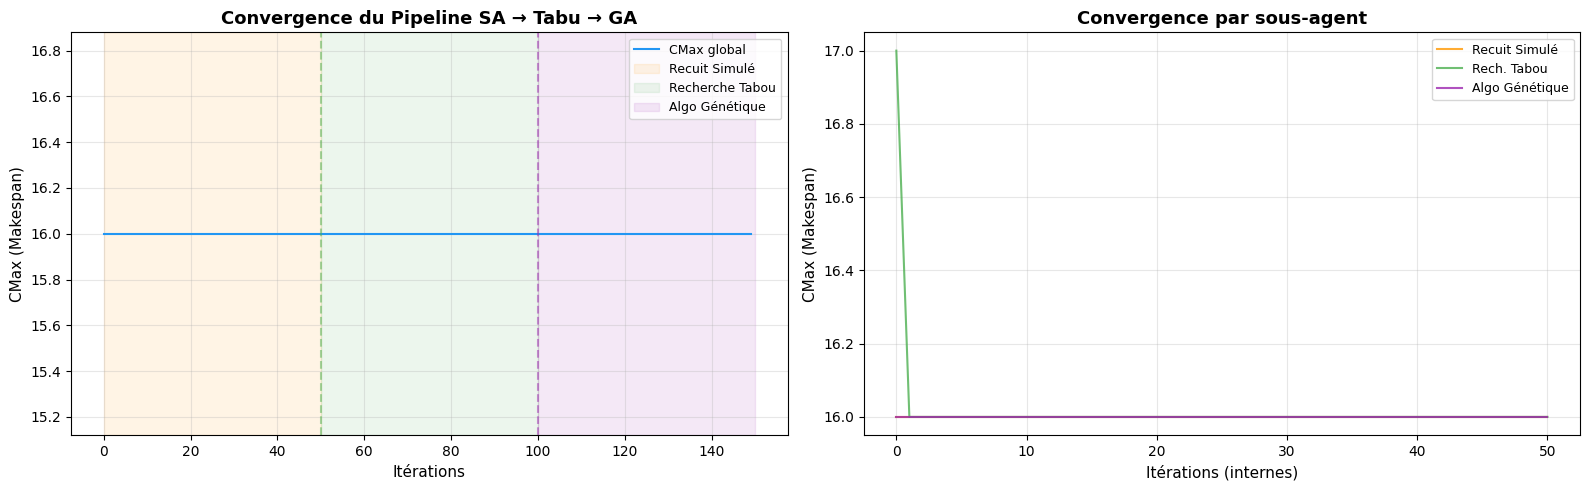


CMax final obtenu : 16
Temps de calcul   : 0.27s


In [12]:
# ============================================================
# VISUALISATION : Convergence du pipeline d'optimisation
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Graphique 1 : Convergence globale ---
ax1 = axes[0]
historique = resultats["historique"]
ax1.plot(historique, color='#2196F3', linewidth=1.5, label='CMax global')

# Marquer les transitions de phases
steps_par_phase = sma.ordonnanceur.steps_par_phase
phases = ["Recuit Simulé", "Recherche Tabou", "Algo Génétique"]
colors = ['#FF9800', '#4CAF50', '#9C27B0']

for i, (phase, color) in enumerate(zip(phases, colors)):
    start = i * steps_par_phase
    end = min((i + 1) * steps_par_phase, len(historique))
    if start < len(historique):
        ax1.axvspan(start, end, alpha=0.1, color=color, label=phase)
        if i > 0 and start < len(historique):
            ax1.axvline(x=start, color=color, linestyle='--', alpha=0.5)

ax1.set_xlabel('Itérations', fontsize=11)
ax1.set_ylabel('CMax (Makespan)', fontsize=11)
ax1.set_title('Convergence du Pipeline SA → Tabu → GA', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# --- Graphique 2 : Convergence par sous-agent ---
ax2 = axes[1]
for agent, color, label in [
    (sma.ordonnanceur.sa_agent, '#FF9800', 'Recuit Simulé'),
    (sma.ordonnanceur.tabu_agent, '#4CAF50', 'Rech. Tabou'),
    (sma.ordonnanceur.ga_agent, '#9C27B0', 'Algo Génétique')
]:
    if agent and agent.historique_makespan:
        ax2.plot(agent.historique_makespan, color=color, linewidth=1.5, label=label, alpha=0.8)

ax2.set_xlabel('Itérations (internes)', fontsize=11)
ax2.set_ylabel('CMax (Makespan)', fontsize=11)
ax2.set_title('Convergence par sous-agent', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCMax final obtenu : {resultats['makespan']}")
print(f"Temps de calcul   : {resultats['duree_calcul']:.2f}s")

C:\Users\87fug\AppData\Local\Temp\ipykernel_16148\3602093416.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', max(nb_patients, 1))


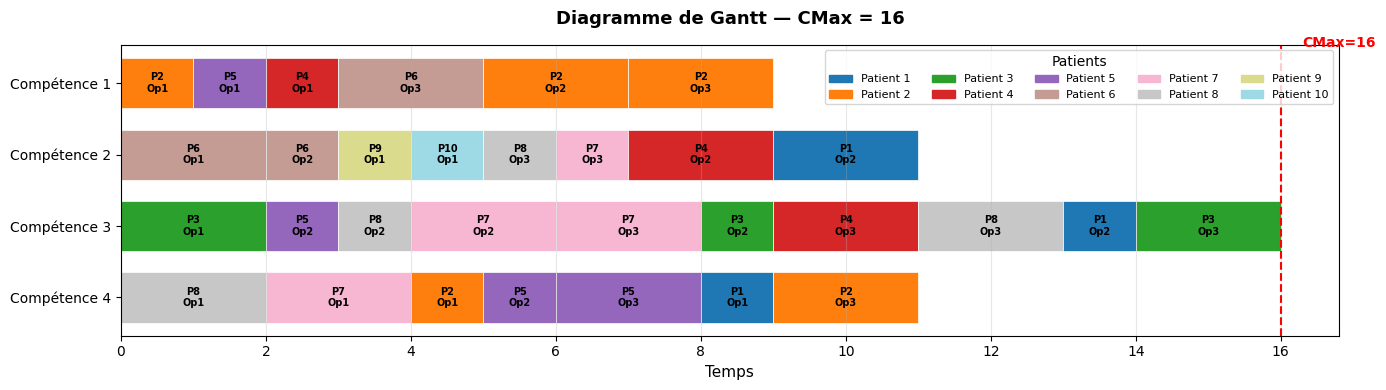

In [13]:
# ============================================================
# VISUALISATION : Diagramme de Gantt du planning
# ============================================================

def plot_gantt(planning, title="Diagramme de Gantt — Planning Hospitalier"):
    """
    Affiche le diagramme de Gantt de la solution décodée.
    
    planning[skill][time] = (patient, op_idx) ou None
    """
    if not planning or not planning[0]:
        print("Planning vide.")
        return
    
    nb_skills = len(planning)
    nb_time = len(planning[0])
    
    # Collecter tous les patients uniques
    patients_set = set()
    for skill_row in planning:
        for cell in skill_row:
            if cell is not None:
                patients_set.add(cell[0])
    
    patients_list = sorted(patients_set)
    nb_patients = len(patients_list)
    
    # Palette de couleurs
    cmap = plt.cm.get_cmap('tab20', max(nb_patients, 1))
    patient_colors = {p: cmap(i) for i, p in enumerate(patients_list)}
    
    fig, ax = plt.subplots(figsize=(max(14, nb_time * 0.5), max(4, nb_skills * 0.8)))
    
    for skill in range(nb_skills):
        t = 0
        while t < nb_time:
            cell = planning[skill][t]
            if cell is not None:
                patient, op_idx = cell
                # Trouver la durée du bloc
                dur = 1
                while t + dur < nb_time and planning[skill][t + dur] == cell:
                    dur += 1
                
                color = patient_colors[patient]
                ax.barh(skill, dur, left=t, height=0.7, 
                       color=color, edgecolor='white', linewidth=0.5)
                ax.text(t + dur/2, skill, f"P{patient+1}\nOp{op_idx+1}",
                       ha='center', va='center', fontsize=7, fontweight='bold')
                t += dur
            else:
                t += 1
    
    ax.set_yticks(range(nb_skills))
    ax.set_yticklabels([f"Compétence {s+1}" for s in range(nb_skills)], fontsize=10)
    ax.set_xlabel("Temps", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Légende
    patches = [mpatches.Patch(color=patient_colors[p], label=f'Patient {p+1}') 
               for p in patients_list]
    ax.legend(handles=patches, loc='upper right', fontsize=8, 
             ncol=min(5, nb_patients), title="Patients")
    
    # Ligne de makespan
    ax.axvline(x=nb_time, color='red', linestyle='--', linewidth=1.5, label=f'CMax={nb_time}')
    ax.text(nb_time + 0.3, -0.5, f'CMax={nb_time}', color='red', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# Afficher le Gantt du planning optimisé
plot_gantt(resultats["planning"], 
           title=f"Diagramme de Gantt — CMax = {resultats['makespan']}")

---
## 4. Simulation de perturbation : Absence de personnel

Ce scénario illustre le **Protocole 2** : un membre du personnel est absent, ce qui déclenche automatiquement un ré-ordonnancement via le SMA.

In [14]:
# ============================================================
# SIMULATION : Perturbation — Absence de personnel
# ============================================================

# On simule de nouveaux patients arrivant, puis une absence
print("=" * 60)
print("  SCÉNARIO : PERTURBATION PAR ABSENCE")
print("=" * 60)

# Générer quelques nouveaux patients
nouveaux_patients = create_patient_data(
    num_patients=5,
    num_operations=3,
    num_competences=nb_competences,
    num_competence_needed_max=2,
    length_competence_needed_max=2
)

print("\n— Arrivée de 5 nouveaux patients —")
sma.simuler_arrivees_batch(nouveaux_patients)
sma.accueil.afficher_file_attente()

# Afficher l'état avant l'absence
print("— État du personnel AVANT absence —")
sma.identificateur.afficher_registre()

# Simuler l'absence du personnel ID=2
print("\n— Simulation de l'absence —")
sma.simuler_absence(personnel_id=2, verbose=True)

print("\n— État du personnel APRÈS absence —")
sma.identificateur.afficher_registre()

  SCÉNARIO : PERTURBATION PAR ABSENCE

— Arrivée de 5 nouveaux patients —

  FILE D'ATTENTE — Agent Accueil
  1. 🟠 Patient_011 | Urgence: TRES_URGENT | 3 ops | Arrivée: t=15.1
  2. 🟢 Patient_012 | Urgence: MOINS_URGENT | 3 ops | Arrivée: t=15.9
  3. 🟢 Patient_014 | Urgence: MOINS_URGENT | 1 ops | Arrivée: t=19.4
  4. ⚪ Patient_013 | Urgence: NON_URGENT | 1 ops | Arrivée: t=17.7
  5. ⚪ Patient_015 | Urgence: NON_URGENT | 1 ops | Arrivée: t=22.4

— État du personnel AVANT absence —

  REGISTRE DU PERSONNEL — Agent Identificateur
  ✅ Interne A                 | Comp: [C2, C4] | disponible
  ✅ Dr. B                     | Comp: [C3, C4] | disponible
  ✅ Dr. C                     | Comp: [C1, C4] | disponible
  ✅ Spéc. D                   | Comp: [C1, C2, C4] | disponible
  ✅ Interne E                 | Comp: [C2] | disponible
  ✅ Dr. F                     | Comp: [C4] | disponible
  ✅ Chirurg. G                | Comp: [C4] | disponible
  ✅ Dr. H                     | Comp: [C3, C4] | dispon

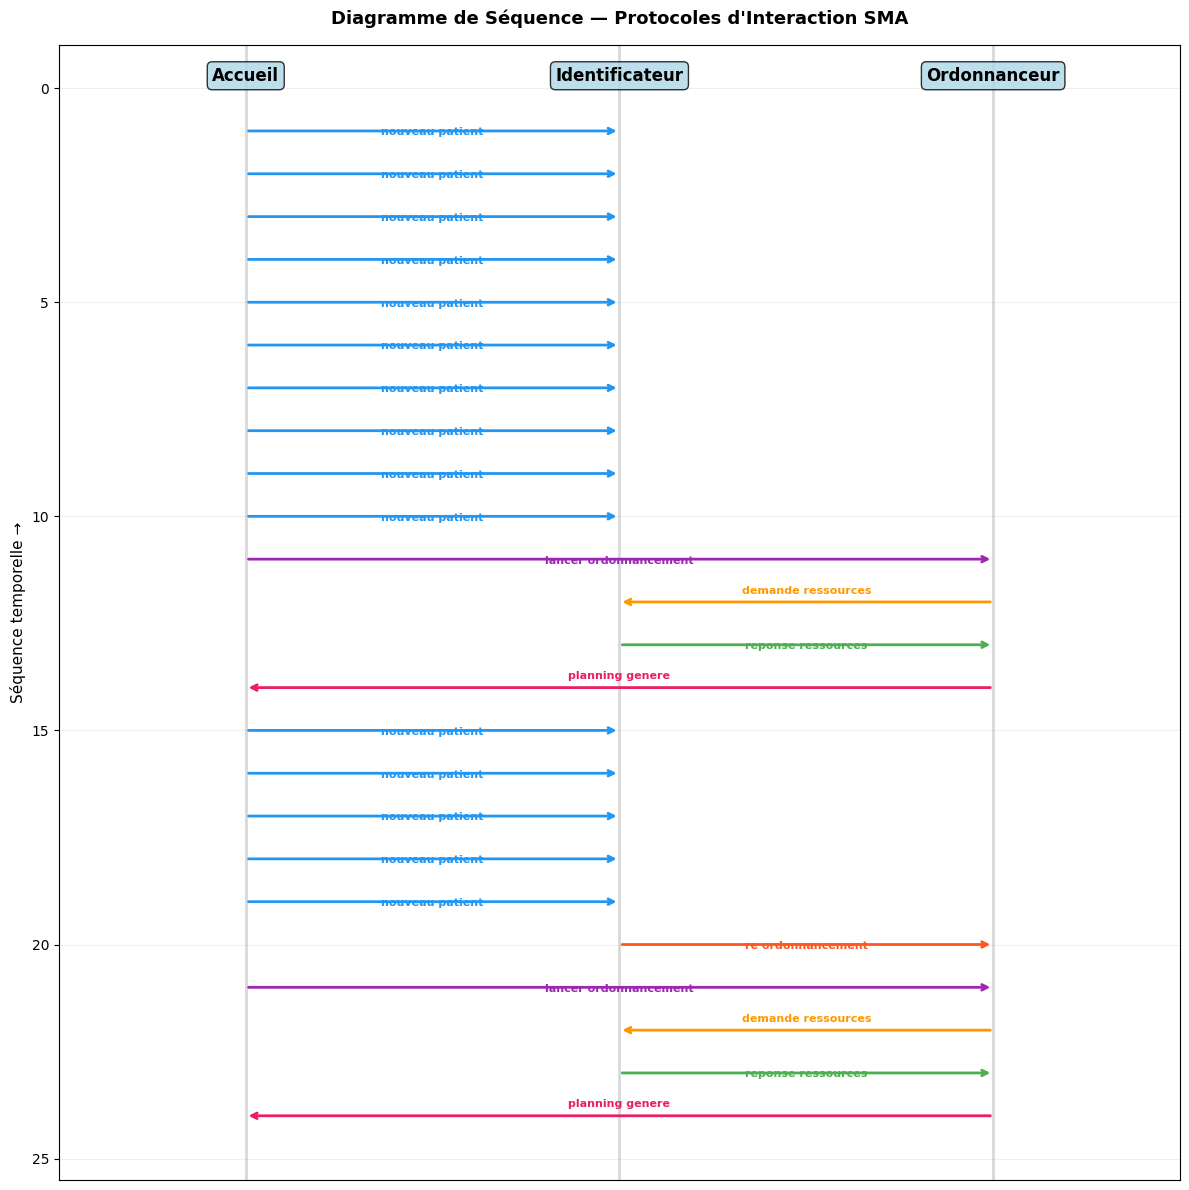

In [15]:
# ============================================================
# VISUALISATION : Diagramme des messages échangés
# ============================================================

def plot_messages_sequence(messages):
    """Affiche un diagramme de séquence des messages entre agents."""
    agents_order = ["Accueil", "Identificateur", "Ordonnanceur"]
    agent_positions = {name: i for i, name in enumerate(agents_order)}
    
    type_colors = {
        "nouveau_patient": '#2196F3',
        "demande_ressources": '#FF9800',
        "reponse_ressources": '#4CAF50',
        "lancer_ordonnancement": '#9C27B0',
        "planning_genere": '#E91E63',
        "absence_personnel": '#F44336',
        "re_ordonnancement": '#FF5722'
    }
    
    fig, ax = plt.subplots(figsize=(12, max(6, len(messages) * 0.5)))
    
    # Lignes de vie des agents
    for name, pos in agent_positions.items():
        ax.axvline(x=pos, color='gray', linestyle='-', linewidth=2, alpha=0.3)
        ax.text(pos, -0.5, name, ha='center', va='top', fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
    
    # Dessiner les messages
    for i, msg in enumerate(messages):
        y = i + 1
        x_from = agent_positions.get(msg.emetteur, 0)
        x_to = agent_positions.get(msg.destinataire, 0)
        color = type_colors.get(msg.type.value, 'gray')
        
        # Flèche
        ax.annotate('', xy=(x_to, y), xytext=(x_from, y),
                   arrowprops=dict(arrowstyle='->', color=color, lw=2))
        
        # Label
        mid_x = (x_from + x_to) / 2
        offset = 0.15 if x_from < x_to else -0.15
        ax.text(mid_x, y + offset, msg.type.value.replace('_', ' '),
               ha='center', va='bottom', fontsize=8, color=color, fontweight='bold')
    
    ax.set_xlim(-0.5, len(agents_order) - 0.5)
    ax.set_ylim(len(messages) + 1.5, -1)
    ax.set_ylabel('Séquence temporelle →', fontsize=11)
    ax.set_xticks([])
    ax.set_title('Diagramme de Séquence — Protocoles d\'Interaction SMA', 
                fontsize=13, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.2)
    
    plt.tight_layout()
    plt.show()


plot_messages_sequence(sma.messages_echanges)

In [16]:
# ============================================================
# BILAN FINAL DE LA SIMULATION
# ============================================================

sma.afficher_bilan()

# Afficher le journal des messages
print("\n" + "=" * 60)
print("  JOURNAL DES MESSAGES ÉCHANGÉS")
print("=" * 60)
for i, msg in enumerate(sma.messages_echanges, 1):
    print(f"  {i:2d}. {msg}")


══════════════════════════════════════════════════════════════════════
  BILAN DU SYSTÈME MULTI-AGENTS
══════════════════════════════════════════════════════════════════════

  📋 Accueil:
     patients_en_attente: 0
     patients_en_cours: 15
     patients_termines: 0
     total_accueillis: 15

  📋 Identificateur:
     personnel_total: 10
     statuts: {'DISPONIBLE': 9, 'OCCUPE': 0, 'ABSENT': 1, 'EN_PAUSE': 0}
     nb_alertes: 0
     nb_absences: 1

  📋 Ordonnanceur:
     meilleur_makespan: 9
     nb_iterations: 150

  📨 Messages échangés: 24
     nouveau_patient: 15
     lancer_ordonnancement: 2
     demande_ressources: 2
     reponse_ressources: 2
     planning_genere: 2
     re_ordonnancement: 1

══════════════════════════════════════════════════════════════════════

  JOURNAL DES MESSAGES ÉCHANGÉS
   1. [nouveau_patient] Accueil → Identificateur (t=1.7)
   2. [nouveau_patient] Accueil → Identificateur (t=3.2)
   3. [nouveau_patient] Accueil → Identificateur (t=4.0)
   4. [nouveau_

---
## 5. Comparaison des modes : Pipeline vs Parallèle

Comparons les deux modes d'orchestration des métaheuristiques :
- **Pipeline** : SA → Tabu → GA (chaîne séquentielle, raffinement progressif)
- **Parallèle** : Les 3 agents travaillent simultanément (exploration diversifiée)

In [17]:
# ============================================================
# COMPARAISON : Pipeline vs Parallèle
# ============================================================

# Utiliser la même matrice pour les deux modes
matrice_test = load_competence_matrix("competence_matrix_10.json")
n_runs = 5  # Nombre de répétitions pour la moyenne
n_steps = 150

results_pipeline = []
results_parallele = []
historiques_pipeline = []
historiques_parallele = []

print("Comparaison Pipeline vs Parallèle")
print(f"  {n_runs} runs × {n_steps} itérations\n")

for run in range(n_runs):
    # Mode Pipeline
    ordo_p = AgentOrdonnanceur(steps_par_phase=50)
    res_p = ordo_p.ordonnancer(matrice_test, mode="pipeline", n_steps=n_steps, verbose=False)
    results_pipeline.append(res_p["makespan"])
    historiques_pipeline.append(res_p["historique"])
    
    # Mode Parallèle
    ordo_par = AgentOrdonnanceur(steps_par_phase=50)
    res_par = ordo_par.ordonnancer(matrice_test, mode="parallele", n_steps=n_steps, verbose=False)
    results_parallele.append(res_par["makespan"])
    historiques_parallele.append(res_par["historique"])
    
    print(f"  Run {run+1}/{n_runs} | Pipeline: {res_p['makespan']} | Parallèle: {res_par['makespan']}")

print(f"\n{'='*50}")
print(f"  Pipeline  — Moy: {np.mean(results_pipeline):.1f} | Min: {min(results_pipeline)} | Max: {max(results_pipeline)}")
print(f"  Parallèle — Moy: {np.mean(results_parallele):.1f} | Min: {min(results_parallele)} | Max: {max(results_parallele)}")
print(f"{'='*50}")

[OK] Matrice chargee depuis: c:\Users\87fug\Documents\centrale\fil_rouge\medical-scheduling\agent\data\competence_matrix_10.json
Comparaison Pipeline vs Parallèle
  5 runs × 150 itérations

  Run 1/5 | Pipeline: 16 | Parallèle: 16
  Run 2/5 | Pipeline: 16 | Parallèle: 16
  Run 3/5 | Pipeline: 16 | Parallèle: 16
  Run 4/5 | Pipeline: 16 | Parallèle: 16
  Run 5/5 | Pipeline: 16 | Parallèle: 16

  Pipeline  — Moy: 16.0 | Min: 16 | Max: 16
  Parallèle — Moy: 16.0 | Min: 16 | Max: 16


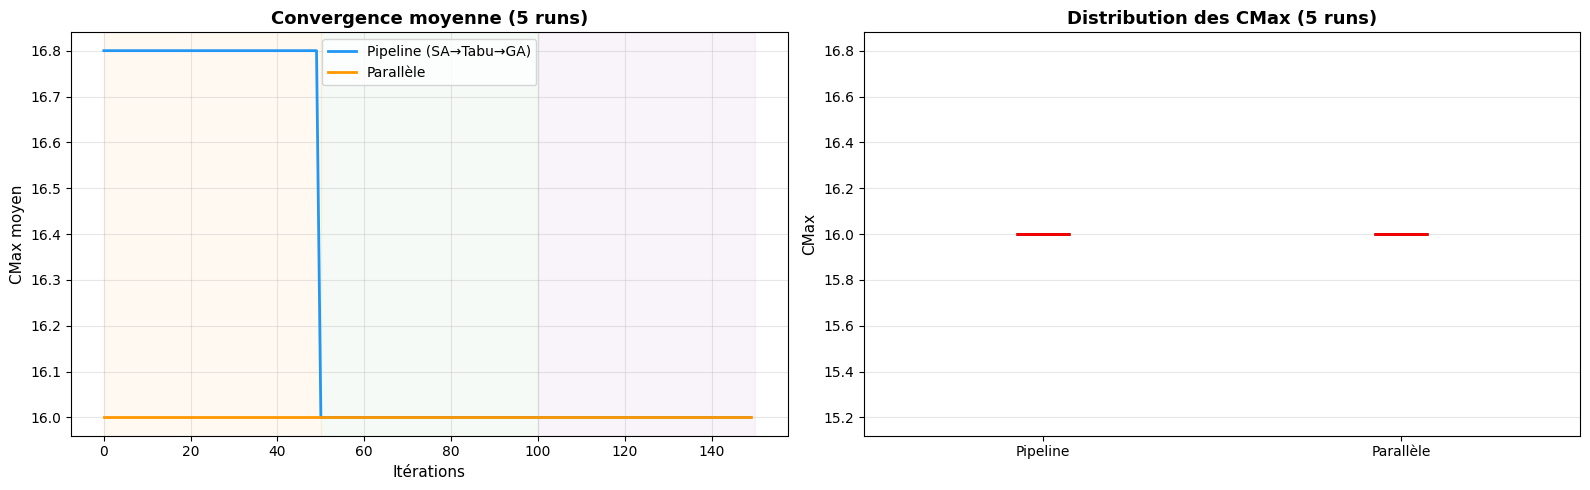

In [18]:
# ============================================================
# VISUALISATION : Comparaison Pipeline vs Parallèle
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Courbes de convergence moyennes ---
ax1 = axes[0]

# Moyenne des historiques
min_len_p = min(len(h) for h in historiques_pipeline)
min_len_par = min(len(h) for h in historiques_parallele)

avg_pipeline = np.mean([h[:min_len_p] for h in historiques_pipeline], axis=0)
avg_parallele = np.mean([h[:min_len_par] for h in historiques_parallele], axis=0)

ax1.plot(avg_pipeline, color='#2196F3', linewidth=2, label='Pipeline (SA→Tabu→GA)')
ax1.plot(avg_parallele, color='#FF9800', linewidth=2, label='Parallèle')

# Phases du pipeline
for i, (phase, color) in enumerate(zip(phases, colors)):
    start = i * 50
    end = (i + 1) * 50
    ax1.axvspan(start, min(end, min_len_p), alpha=0.05, color=color)

ax1.set_xlabel('Itérations', fontsize=11)
ax1.set_ylabel('CMax moyen', fontsize=11)
ax1.set_title(f'Convergence moyenne ({n_runs} runs)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# --- Box plot ---
ax2 = axes[1]
bp = ax2.boxplot([results_pipeline, results_parallele], 
                  labels=['Pipeline', 'Parallèle'],
                  patch_artist=True,
                  boxprops=dict(linewidth=2),
                  medianprops=dict(color='red', linewidth=2))

bp['boxes'][0].set_facecolor('#BBDEFB')
bp['boxes'][1].set_facecolor('#FFE0B2')

ax2.set_ylabel('CMax', fontsize=11)
ax2.set_title(f'Distribution des CMax ({n_runs} runs)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 6. Synthèse

### Architecture retenue

| Agent | Rôle | Entrées | Sorties |
|-------|------|---------|--------|
| **Accueil** | Accueil, triage, file d'attente | Patients arrivants | Matrice de compétences, priorités |
| **Identificateur** | Gestion des ressources | Personnel, compétences | Disponibilités, alertes absences |
| **Ordonnanceur** | Optimisation du planning | Matrice + ressources | Planning optimal (CMax minimisé) |

### Points forts du SMA

1. **Modularité** : Chaque agent a une responsabilité claire et bien définie
2. **Réactivité** : Les perturbations (absence, nouveau patient critique) déclenchent automatiquement un ré-ordonnancement
3. **Optimisation robuste** : Le pipeline de 3 métaheuristiques combine exploration (SA), intensification (Tabu) et diversification (GA)
4. **Communication structurée** : Les protocoles d'interaction sont bien définis via des messages typés
5. **Scalabilité** : Le système peut être étendu avec de nouveaux agents (ex: Agent Logistique, Agent Bloc Opératoire)

### Intégration dans le système global

Ce SMA constitue le **module d'ordonnancement** du système plus global. Il peut être intégré comme un agent autonome dans une architecture plus large incluant :
- Gestion des lits et chambres
- Logistique pharmaceutique
- Coordination inter-services
- Prédiction des flux patients (ML)